In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

There are two different .csv files for this exercise:
* takehome_user_engagement:
    * A usage summary table that has a row for each day that a user logged into the product.
* takehome_users:
    * A user table with data on 12,000 users who signed up for the product in the last two years.



In [2]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'],index_col='time_stamp')
user_engagement_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [3]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin1', parse_dates=['creation_time'])
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Question to be answered

Defining an **"Adopted user"** as a user who has logged into the product on three separate days in at least one seven-day period, **identify which factors predict future user adoption.**

Strategy
1. Identify which users are the adopted users. Get this information from the user_engagement table.
2. Label which users are adopted users and which ones are not and add the result to users table.
3. Find which factors are import in order to predict future adoption. Get information from the users table.

In [4]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
dtypes: int64(2)
memory usage: 4.8 MB


In [5]:
# How many unique users in this dataset
user_qty = user_engagement_df['user_id'].nunique()

print('There are {} unique users'.format(user_qty))

There are 8823 unique users


In [6]:
# Find which users loged in at least 3 different days during on a 7 day rolling window.
# Add the results to a dictionary with 1 representing True and 0 Representing False

unique_users = user_engagement_df['user_id'].unique()
adopted_user = defaultdict(int)

for user in unique_users:
    data = user_engagement_df[user_engagement_df['user_id'] == user]
    adopted = np.sum(data['visited'].resample('1D').rolling(7).count() >=3)
    if adopted != 0:
        adopted_user[user] += 1
    else:
        adopted_user[user] += 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.resample() is now a deferred operation
You called rolling(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  if __name__ == '__main__':


In [7]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [8]:
# Add the results to the Users Dataframe.
users_df['adopted_user'] = users_df['object_id'].apply(lambda x: adopted_user[x])

In [9]:
# How many users have adopted vs. users who have not adopted?
agg = users_df.groupby('adopted_user').size().reset_index().rename(columns={0:'count'})
agg['pct'] = agg['count'] / len(users_df) * 100
agg

,adopted_user,count,pct
0,0,10398,86.65
1,1,1602,13.35


### EDA on features

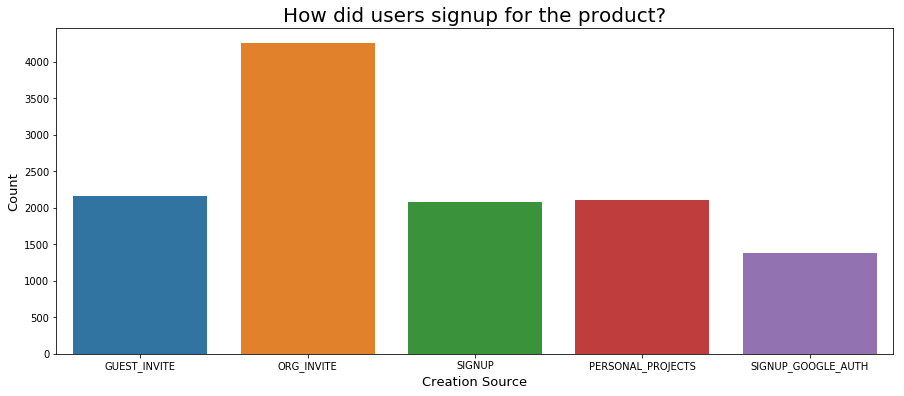

In [10]:
plt.figure(figsize=(15, 6))

sns.countplot(x = 'creation_source', data=users_df)

plt.title('How did users signup for the product?', size=20)
plt.xlabel('Creation Source', size=13)
plt.ylabel('Count', size=13)

plt.show()



In [11]:
# These categories mean users were invited to use the product
invite = ['PERSONAL_PROJECTS', 'GUEST_INVITE', 'ORG_INVITE']

# These mean the users found the product on their own
own = ['SIGNUP', 'SIGNUP_GOOGLE_AUTH']

# Aggragate the two reasons and add it back to the dataframe
creation = {}

for i in users_df['creation_source']:
    if i in invite:
        creation[i] = 'invited'
    if i in own:
        creation[i] = 'not_invited'

# Add result to users_df
users_df['invited'] = users_df['creation_source'].apply(lambda x: creation[x])

In [12]:
# How many users were invited vs. came on their own
agg = users_df.groupby('invited').size().reset_index().rename(columns={0:'count'})
agg['pct'] = agg['count'] / len(users_df) * 100
agg

,invited,count,pct
0,invited,8528,71.066667
1,not_invited,3472,28.933333


The majority of users came to this company via invitation rather than on their own. There may be a correlation between users who came to the site on their own and user adoption.

In [13]:
# How many different Group Organizations exists within this product?
users_df['org_id'].nunique()

417

In [14]:
# How many users have opted in to receive marketing emails?
users_df['opted_in_to_mailing_list'].value_counts()

0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

In [15]:
# How many users enabled marketing drip
users_df['enabled_for_marketing_drip'].value_counts()

0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64

### Predictive Model

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn import decomposition, metrics
from sklearn.preprocessing import MinMaxScaler

In [17]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null int64
invited                       12000 non-null object
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 1.1+ MB


In [18]:
# Take care of missing values
users_df.fillna(0, inplace=True)

In [19]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
adopted_user                  12000 non-null int64
invited                       12000 non-null object
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 1.1+ MB


In [20]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,invited
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,invited
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,invited
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,invited
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,invited


In [21]:
# Convert text fields to intergers
creation_source_dict = {'GUEST_INVITE':1, 'ORG_INVITE':2, 'SIGNUP':3, 'PERSONAL_PROJECTS':4, 'SIGNUP_GOOGLE_AUTH':5}
users_df['creation_source'] = users_df['creation_source'].apply(lambda x: creation_source_dict[x])

# Convert invited field to intergers
invited_dict = {'not_invited':1, 'invited':2}
users_df['invited'] = users_df['invited'].apply(lambda x: invited_dict[x])

In [22]:
# Select features to use
chosen_ones = ['creation_source', 'invited', 'last_session_creation_time', 'opted_in_to_mailing_list', 
               'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']

feature = users_df[chosen_ones]
label = users_df['adopted_user']

In [23]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
creation_source               12000 non-null int64
invited                       12000 non-null int64
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
dtypes: float64(2), int64(5)
memory usage: 656.3 KB


In [24]:
label.value_counts()

0    10398
1     1602
Name: adopted_user, dtype: int64

##### Run different models and check for accuracy

LinearSVC

In [25]:
linear = LinearSVC()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

In [26]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.87      1.00      0.93      2615
          1       0.00      0.00      0.00       385

avg / total       0.76      0.87      0.81      3000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
# Linear SVC with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LinearSVC(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.80
Best parameters:  {'C': 1}


Logistic Regression

In [28]:
logistic = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

In [29]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.87      1.00      0.93      2615
          1       0.00      0.00      0.00       385

avg / total       0.76      0.87      0.81      3000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
# Logistic Regression with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.87
Best parameters:  {'C': 0.001}


Random Forest

In [31]:
forest = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    label,
                                                    random_state=4)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [32]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      2615
          1       0.70      0.50      0.58       385

avg / total       0.90      0.91      0.90      3000



In [33]:
# Random Forest Classifier with GridSearchCV
X_test, X_train, y_test, y_train = train_test_split(feature,
                                                    label,
                                                    test_size = 0.3,
                                                    random_state = 4)

param_grid = {'n_estimators': [1, 3, 5, 10, 15, 20]}
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('Best cross_validation score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)

Best cross_validation score: 0.92
Best parameters:  {'n_estimators': 20}


Feature Importance

In [34]:
# Based on the three models run above, the best performing model is Random Forest, though not by much. Let's use Random Forest to move forward in this exercise

print('Feature Importance')
print('-----------------------------')
for index, value in enumerate(forest.feature_importances_):
    print('{:20}          {:3f}'.format(chosen_ones[index], value))


Feature Importance
-----------------------------
creation_source               0.014213
invited                       0.002995
last_session_creation_time          0.693686
opted_in_to_mailing_list          0.006721
enabled_for_marketing_drip          0.008068
org_id                        0.169516
invited_by_user_id            0.104801


Random forest is the most accurate model with 95% accuracy.

According to the findings above, there are three features which are more important than the rest:
* Last time the user loged in (last_session_creation_time)
* Which group of users the user belongs to (org_id)
* Which user invited them to join (invited_by_user_id)